In [ ]:
pip install coolprop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 44.7 MB/s eta 0:00:00


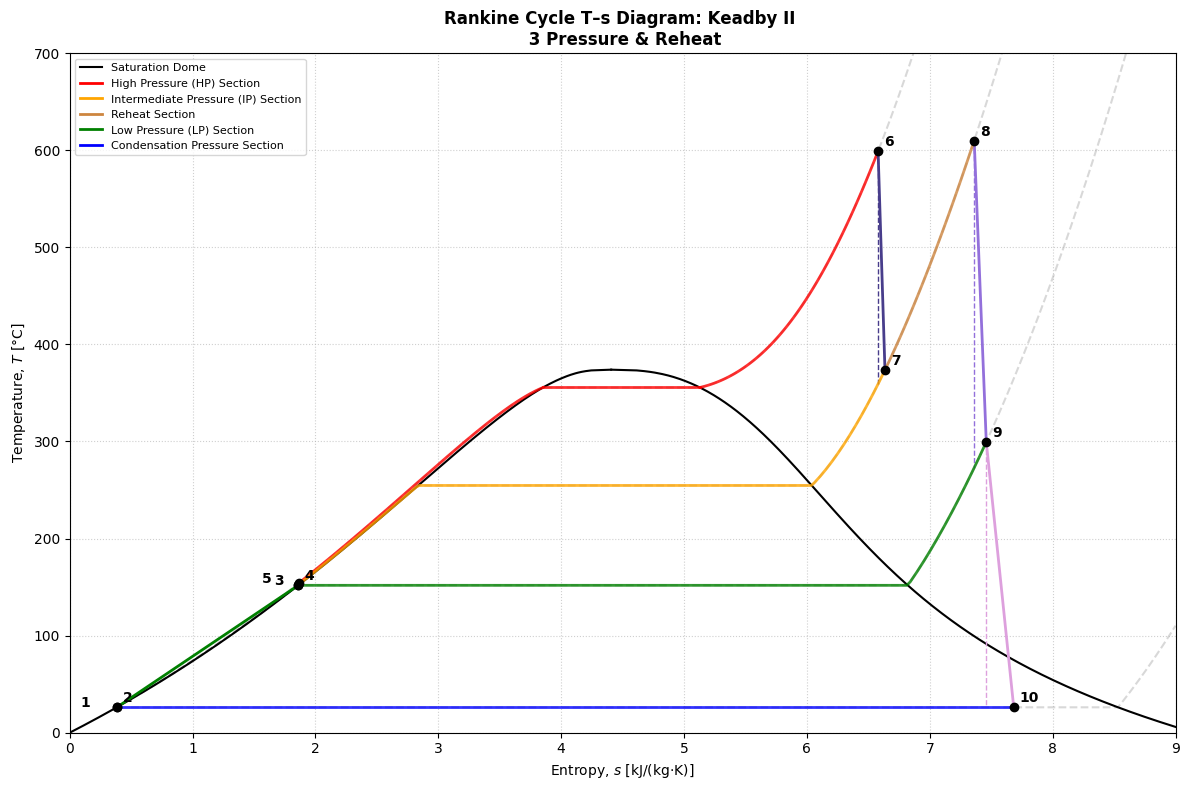


######################################################################
## Power and Work Summary (MW)
######################################################################
### Turbine Work Output (Mechanical Power Produced)
- W_T_HP: 62.77 MW
- W_T_IP: 105.51 MW
- W_T_LP: 137.53 MW
Total Gross Turbine Work (Sum W_T): 305.81 MW

### Pump Work Input (Mechanical Power Consumed)
- W_P_LP (1->2): 0.10 MW
- W_P_IP (3->4): 0.81 MW
- W_P_HP (4->5): 2.61 MW
Total Pump Work (Sum W_P): 3.53 MW

### Net Power and Efficiency
Total Mechanical Power Output (W_T_Total * eta_turb): 302.75 MW
Total Mechanical Power Input (W_P_Total / eta_pump): 3.57 MW
---
Net Mechanical Power (W_Net_Mech): 299.19 MW
Net Electric Power (W_Net_Elec): 295.00 MW
Cycle Efficiency (eta_cycle): 42.56%

######################################################################
## Sequential Flue Gas Temperature Drop Across HEXs
######################################################################
|   No. | HEX Name             

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from CoolProp.CoolProp import PropsSI


# --- INPUT PARAMETERS ---
# Pressures (Pa)
p_hp = 177e5       # HP: 177 bar
p_reheat = 43e5    # IP/Reheat: 43 bar
p_lp = 5e5         # LP: 5 bar
p_cond = 0.034e5   # Condenser: 0.034 bar
pressures = [p_hp, p_reheat, p_lp, p_cond]


# Temperatures (K)
T_hp_superheat = 599 + 273.15 # 599 °C
T_reheat_hot = 610 + 273.15   # 610 °C
T_amb = 10 # °C


# Mass flow rates (kg/s)
m_dot_HP = 152.5             # Mass flow entering HP turbine
m_dot_IP_add = 14.44         # Mass flow added before IP section
m_dot_LP_add = 11.94         # Mass flow added before LP section


# Calculated mass flow rates
m_dot_IP = m_dot_HP + m_dot_IP_add # Flow through IP turbine / IP reheater
m_dot_LP = m_dot_IP + m_dot_LP_add # Flow through LP turbine / Condensate Pump (1->2)


# Efficiencies
eta_turb_isen = 0.92
eta_pump_isen = 0.85
eta_pump_mech = 0.99
eta_turb_mech = 0.99
eta_gen = 0.986


# --- FLUE GAS PARAMETERS ---
T_fg_in = 670 + 273.15     # 670 °C (K)
m_dot_fg = 1004.14        # kg/s
c_p_fg = 1.2136         # kJ/(kg·K)

# ----------------------------------------------------------------------
# --- A. CYCLE STATE POINT CALCULATIONS (1 → 10) ---
# ----------------------------------------------------------------------
P1 = p_cond
h1 = PropsSI('H', 'P', P1, 'Q', 0, 'Water') / 1000
s1 = PropsSI('S', 'P', P1, 'Q', 0, 'Water') / 1000

P2 = p_lp
h2s = PropsSI('H', 'P', P2, 'S', s1 * 1000, 'Water') / 1000
h2 = h1 + (h2s - h1) / eta_pump_isen
s2 = PropsSI('S', 'P', P2, 'H', h2 * 1000, 'Water') / 1000


P3 = p_lp
h3 = PropsSI('H', 'P', P3, 'Q', 0, 'Water') / 1000
s3 = PropsSI('S', 'P', P3, 'Q', 0, 'Water') / 1000

P4 = p_reheat
h4s = PropsSI('H', 'P', P4, 'S', s3 * 1000, 'Water') / 1000
h4 = h3 + (h4s - h3) / eta_pump_isen
s4 = PropsSI('S', 'P', P4, 'H', h4 * 1000, 'Water') / 1000


P5 = p_hp
h5s = PropsSI('H', 'P', P5, 'S', s4 * 1000, 'Water') / 1000
h5 = h4 + (h5s - h4) / eta_pump_isen
s5 = PropsSI('S', 'P', P5, 'H', h5 * 1000, 'Water') / 1000

P6 = p_hp
T6 = T_hp_superheat
h6 = PropsSI('H', 'P', P6, 'T', T6, 'Water') / 1000
s6 = PropsSI('S', 'P', P6, 'T', T6, 'Water') / 1000


P7 = p_reheat
h7s = PropsSI('H', 'P', P7, 'S', s6 * 1000, 'Water') / 1000
h7 = h6 - eta_turb_isen * (h6 - h7s)
s7 = PropsSI('S', 'P', P7, 'H', h7 * 1000, 'Water') / 1000
T6s = PropsSI('T', 'P', P7, 'H', h7s * 1000, 'Water')


P8 = p_reheat
T8 = T_reheat_hot
h8 = PropsSI('H', 'P', P8, 'T', T8, 'Water') / 1000
s8 = PropsSI('S', 'P', P8, 'T', T8, 'Water') / 1000

P9 = p_lp
h9s = PropsSI('H', 'P', P9, 'S', s8 * 1000, 'Water') / 1000
h9 = h8 - eta_turb_isen * (h8 - h9s)
s9 = PropsSI('S', 'P', P9, 'H', h9 * 1000, 'Water') / 1000
T8s = PropsSI('T', 'P', P9, 'H', h9s * 1000, 'Water')


P10 = p_cond
h10s = PropsSI('H', 'P', P10, 'S', s9 * 1000, 'Water') / 1000
h10 = h9 - eta_turb_isen * (h9 - h10s)
s10 = PropsSI('S', 'P', P10, 'H', h10 * 1000, 'Water') / 1000
T10s = PropsSI('T', 'P', P10, 'H', h10s * 1000, 'Water')


# --- SATURATED PROPERTIES FOR Q CALCULATION & TABLES ---
h_liq_HP = PropsSI('H', 'P', p_hp, 'Q', 0, 'Water') / 1000
h_vap_HP = PropsSI('H', 'P', p_hp, 'Q', 1, 'Water') / 1000
T_sat_HP = PropsSI('T', 'P', p_hp, 'Q', 0, 'Water')

h_liq_IP = PropsSI('H', 'P', p_reheat, 'Q', 0, 'Water') / 1000
h_vap_IP = PropsSI('H', 'P', p_reheat, 'Q', 1, 'Water') / 1000
T_sat_IP = PropsSI('T', 'P', p_reheat, 'Q', 0, 'Water')

h_liq_LP = PropsSI('H', 'P', p_lp, 'Q', 0, 'Water') / 1000
h_vap_LP = PropsSI('H', 'P', p_lp, 'Q', 1, 'Water') / 1000
T_sat_LP = PropsSI('T', 'P', p_lp, 'Q', 0, 'Water')

# ----------------------------------------------------------------------
# --- B. THERMAL HEAT DUTY CALCULATIONS (Q in kW) ---
# ----------------------------------------------------------------------

# Define HEX duties and map them for sequential calculation
HEX_DUTY_MAP = {

    'IPRH': {'name': 'IP Reheater (IPRH)', 'm': m_dot_IP, 'h_out': h8, 'h_in': h7},
    'HPSH': {'name': 'HP Superheater (HPSH)', 'm': m_dot_HP, 'h_out': h6, 'h_in': h_vap_HP},
    'HPEVAP': {'name': 'HP Evaporator (HPEVAP)', 'm': m_dot_HP, 'h_out': h_vap_HP, 'h_in': h_liq_HP},
    'IPSH': {'name': 'IP Superheater (IPSH)', 'm': m_dot_IP_add, 'h_out': h7, 'h_in': h_vap_IP},
    'HPECO': {'name': 'HP Economizer (HPECO)', 'm': m_dot_HP, 'h_out': h_liq_HP, 'h_in': h5},
    'IPEVAP': {'name': 'IP Evaporator (IPEVAP)', 'm': m_dot_IP_add, 'h_out': h_vap_IP, 'h_in': h_liq_IP},
    'LPSH': {'name': 'LP Superheater (LPSH)', 'm': m_dot_LP_add, 'h_out': h9, 'h_in': h_vap_LP},
    'IPECO': {'name': 'IP Economizer (IPECO)', 'm': m_dot_IP_add, 'h_out': h_liq_IP, 'h_in': h4},
    'LPEVAP': {'name': 'LP Evaporator (LPEVAP)', 'm': m_dot_LP_add, 'h_out': h_vap_LP, 'h_in': h_liq_LP},
    'LPECO': {'name': 'LP Economizer (LPECO)', 'm': m_dot_LP, 'h_out': h3, 'h_in': h2},
}

# Calculate and store Q (kW and MW) for all HEXs
for key in HEX_DUTY_MAP:
    duty = HEX_DUTY_MAP[key]
    Q_hex = duty['m'] * (duty['h_out'] - duty['h_in'])
    duty['Q_kW'] = Q_hex
    duty['Q_MW'] = Q_hex / 1000

# ----------------------------------------------------------------------
# --- C. SEQUENTIAL FLUE GAS TEMPERATURE CALCULATION ---
# ----------------------------------------------------------------------

# Flue Gas (FG) Parameters
C_fg = m_dot_fg * c_p_fg # kW/K
T_fg_current_K = T_fg_in # Start at the inlet temp

# Heat Exchanger Sequence (as requested: IPRH, HPSH, HPEVAP, IPSH, HPECO, IPEVAP, LPSH, IPECO, LPEVAP, LPECO)
HEX_SEQUENCE = [
    'IPRH', 'HPSH', 'HPEVAP', 'IPSH', 'HPECO',
    'IPEVAP', 'LPSH', 'IPECO', 'LPEVAP', 'LPECO'
]

fg_analysis_data = []

for i, hex_key in enumerate(HEX_SEQUENCE):
    hex_data = HEX_DUTY_MAP[hex_key]

    # Flue Gas Inlet Temp for this HEX (which is the outlet of the previous one)
    T_fg_in_K = T_fg_current_K

    # Heat transferred to steam (using max(0, Q_kW) to ignore the small negative duty from IPECO if it happens)
    Q_hex_kW = hex_data['Q_kW']
    Q_steam_kW = max(0, Q_hex_kW)

    # Calculate Flue Gas Temperature Drop
    Delta_T_fg = Q_steam_kW / C_fg # K

    # Calculate Flue Gas Outlet Temperature
    T_fg_out_K = T_fg_in_K - Delta_T_fg

    fg_analysis_data.append({
        'No.': i + 1,
        'HEX Name': hex_data['name'],
        'Heat Transferred (Q_MW)': Q_hex_kW / 1000, # Show the true Q_MW value
        'ΔT_fg (K)': Delta_T_fg,
        'T_fg,in (°C)': T_fg_in_K - 273.15,
        'T_fg,out (°C)': T_fg_out_K - 273.15,
    })

    # CRITICAL FIX: Update current flue gas temperature for the next HEX's inlet
    T_fg_current_K = T_fg_out_K

df_fg_sequence = pd.DataFrame(fg_analysis_data)
T_fg_final_out_C = T_fg_current_K - 273.15
# Q_total_MW is the sum of all heat absorbed by the steam cycle components
Q_total_MW = df_fg_sequence[df_fg_sequence['Heat Transferred (Q_MW)'] > 0]['Heat Transferred (Q_MW)'].sum()


c_p_fg_out = 1.0797

Q_fg_loss = m_dot_fg*c_p_fg_out*(T_fg_final_out_C-T_amb)/1000
Q_cond = m_dot_LP*(h10-h1)/1000


# ----------------------------------------------------------------------
# --- D. TABLE GENERATION FOR CYCLE POINTS (1 → 10) ---
# ----------------------------------------------------------------------

actual_points = {
    '1 (Cond. Sat Liq)': {'P': P1, 'H': h1, 'S': s1}, '2 (Pumped LP)': {'P': P2, 'H': h2, 'S': s2},
    '3 (Sat LP Liq)': {'P': P3, 'H': h3, 'S': s3}, '4 (Pumped IP)': {'P': P4, 'H': h4, 'S': s4},
    '5 (Pumped HP)': {'P': P5, 'H': h5, 'S': s5}, '6 (SHP Turb In)': {'P': P6, 'H': h6, 'S': s6},
    '7 (HP Turb Ex)': {'P': P7, 'H': h7, 'S': s7}, '8 (Reheat/IP In)': {'P': P8, 'H': h8, 'S': s8},
    '9 (IP Turb Ex)': {'P': P9, 'H': h9, 'S': s9}, '10 (LP Turb Ex)': {'P': P10, 'H': h10, 'S': s10}
}

table_data = {}

for name, props in actual_points.items():
    P = props['P']; H = props['H'] * 1000; S = props['S'] * 1000
    T = PropsSI('T', 'P', P, 'H', H, 'Water')
    try: Q = PropsSI('Q', 'P', P, 'H', H, 'Water')
    except: Q = float('nan')
    table_data[name] = {
        'P (bar)': P / 1e5, 'T (°C)': T - 273.15, 'h (kJ/kg)': H / 1000, 's (kJ/kg·K)': S / 1000,
        'Quality (x)': Q if not np.isnan(Q) else ('Superheated' if T > PropsSI('T', 'P', P, 'Q', 1, 'Water') else 'Subcooled')

    }

df_cycle = pd.DataFrame.from_dict(table_data, orient='index').reindex(['1 (Cond. Sat Liq)', '2 (Pumped LP)', '3 (Sat LP Liq)', '4 (Pumped IP)', '5 (Pumped HP)', '6 (SHP Turb In)', '7 (HP Turb Ex)', '8 (Reheat/IP In)', '9 (IP Turb Ex)', '10 (LP Turb Ex)'])
Ts = df_cycle['T (°C)'] + 273.15; Ss = df_cycle['s (kJ/kg·K)']


df_sat = pd.DataFrame([
    {'Pressure (bar)': p_hp / 1e5, 'T_sat (°C)': T_sat_HP - 273.15, 'h_liq (kJ/kg)': h_liq_HP, 'h_vap (kJ/kg)': h_vap_HP},
    {'Pressure (bar)': p_reheat / 1e5, 'T_sat (°C)': T_sat_IP - 273.15, 'h_liq (kJ/kg)': h_liq_IP, 'h_vap (kJ/kg)': h_vap_IP},
    {'Pressure (bar)': p_lp / 1e5, 'T_sat (°C)': T_sat_LP - 273.15, 'h_liq (kJ/kg)': h_liq_LP, 'h_vap (kJ/kg)': h_vap_LP},

])


# ----------------------------------------------------------------------
# --- G. POWER OUTPUT CALCULATIONS (in MW) ---
# ----------------------------------------------------------------------

# 1. Pump Work (kW)
# Assuming 1->2 is LP pump (m_dot_LP), 3->4 is IP pump (m_dot_IP), 4->5 is HP pump (m_dot_HP) based on mass flows
W_P_LP_kW = m_dot_LP * (h2 - h1)
W_P_IP_kW = m_dot_IP * (h4 - h3)
W_P_HP_kW = m_dot_HP * (h5 - h4)

W_P_Total_kW = W_P_LP_kW + W_P_IP_kW + W_P_HP_kW


# 2. Turbine Work (kW)
# HP Turbine: 6->7 (m_dot_HP)
W_T_HP_kW = m_dot_HP * (h6 - h7)
# IP Turbine: 8->9 (m_dot_IP)
W_T_IP_kW = m_dot_IP * (h8 - h9)
# LP Turbine: 9->10 (m_dot_LP)
W_T_LP_kW = m_dot_LP * (h9 - h10)

W_T_Total_kW = W_T_HP_kW + W_T_IP_kW + W_T_LP_kW


# 3. Total Net Power (MW)
W_T_Mech_MW = (W_T_Total_kW * eta_turb_mech) / 1000
W_P_Mech_MW = (W_P_Total_kW / eta_pump_mech) / 1000 # Electrical power input to pumps

Mech_Loss = (W_P_Mech_MW - W_P_Total_kW/1000)+(W_T_Total_kW/1000-W_T_Mech_MW)

W_Net_Mech_MW = W_T_Mech_MW - W_P_Mech_MW
W_Net_Elec_MW = W_Net_Mech_MW * eta_gen

El_Loss = W_Net_Mech_MW-W_Net_Elec_MW

Losses = Mech_Loss + El_Loss

# Convert all pump/turbine work to MW for printing
W_P_LP_MW = W_P_LP_kW / 1000
W_P_IP_MW = W_P_IP_kW / 1000
W_P_HP_MW = W_P_HP_kW / 1000
W_P_Total_MW = W_P_Total_kW / 1000

W_T_HP_MW = W_T_HP_kW / 1000
W_T_IP_MW = W_T_IP_kW / 1000
W_T_LP_MW = W_T_LP_kW / 1000
W_T_Total_MW = W_T_Total_kW / 1000

# Calculate Cycle Efficiency
eta_cycle = W_Net_Elec_MW / Q_total_MW if Q_total_MW > 0 else 0.0





# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# --- E. PLOTTING CODE (MODIFIED FOR CUSTOM LEGEND) ---
# ----------------------------------------------------------------------

def plot_isobaric(p, s_start, s_end, color, linestyle, ax, label=None, lw=2):
    """Plots a line of constant pressure between two entropy bounds."""
    s_vals = np.linspace(s_start * 1000, s_end * 1000, 100)
    T_vals = []; s_plot_vals = []
    for s in s_vals:
        try: T = PropsSI('T', 'P', p, 'S', s, 'Water'); T_vals.append(T); s_plot_vals.append(s / 1000)
        except: pass

    # Removed 'label' from the line plot here to avoid unwanted legend entries
    ax.plot(s_plot_vals, np.array(T_vals) - 273.15, color=color, ls=linestyle, lw=lw, alpha=0.8)


def plot_background_isobars(ax, pressures):
    """Plots faint background isobars for context."""
    for p in pressures:
        s_range = np.linspace(0.5, 9, 400); T_vals, s_vals = [], []
        for s in s_range * 1000:
            try: T = PropsSI('T','P',p,'S',s,'Water')
            except: continue
            if np.isfinite(T): s_vals.append(s/1000); T_vals.append(T)
        ax.plot(s_vals, np.array(T_vals)-273.15, '--', color='gray', alpha=0.3, zorder=0)


def plot_isobaric_line_between_points(p, s_start, s_end, ax, color='m', lw=2, linestyle='--', label=None):
    """Plots a line of constant pressure precisely between two state points."""
    s_vals = np.linspace(s_start * 1000, s_end * 1000, 200)
    T_vals = []; s_plot_vals = []
    for s in s_vals:
        try: T = PropsSI('T', 'P', p, 'S', s, 'Water')
        except: continue
        if np.isfinite(T): s_plot_vals.append(s / 1000); T_vals.append(T - 273.15)
    # Removed 'label' from the line plot here to avoid unwanted legend entries
    ax.plot(s_plot_vals, T_vals, color=color, lw=lw, ls=linestyle, alpha=0.8)


# Full T-s diagram
fig1, ax1 = plt.subplots(figsize=(12, 8))
plot_background_isobars(ax1, pressures)


# Saturation dome
T_min = PropsSI('Ttriple', 'Water'); T_crit = PropsSI('Tcrit', 'Water')
T_sat_curve = np.linspace(T_min, T_crit, 500)
s_liq = np.array([PropsSI('S', 'T', T, 'Q', 0, 'Water') for T in T_sat_curve]) / 1000
s_vap = np.array([PropsSI('S', 'T', T, 'Q', 1, 'Water') for T in T_sat_curve]) / 1000
# Set Saturation Dome label here
ax1.plot(s_liq, T_sat_curve-273.15, 'k-', label='Saturation Dome')
ax1.plot(s_vap, T_sat_curve-273.15, 'k-')


# Pumping and heating lines (Labels removed or set to None)
ax1.plot([s1, s2], [Ts['1 (Cond. Sat Liq)']-273.15, Ts['2 (Pumped LP)']-273.15], 'k-', lw=1.5) # Pumping (Actual)
ax1.plot([s2, s3], [Ts['2 (Pumped LP)']-273.15, Ts['3 (Sat LP Liq)']-273.15], 'g-', lw=2) # Feedwater Heating
ax1.plot([s3, s4], [Ts['3 (Sat LP Liq)']-273.15, Ts['4 (Pumped IP)']-273.15], 'k-', lw=1.5)
ax1.plot([s4, s5], [Ts['4 (Pumped IP)']-273.15, Ts['5 (Pumped HP)']-273.15], 'r-', lw=1.5)

# Boiler (5 → 6)
s_hp_liq = PropsSI('S', 'P', p_hp, 'Q', 0, 'Water')/1000
s_hp_vap = PropsSI('S', 'P', p_hp, 'Q', 1, 'Water')/1000
T_hp_sat = PropsSI('T','P',p_hp,'Q',0,'Water')

# 5 to saturation liquid heating must follow the HP isobar.
plot_isobaric_line_between_points(p_hp, s5, s_hp_liq, ax1, color='r', lw=2, linestyle='-')

# Evaporation/Superheat (No label)
plot_isobaric(p_hp, s_hp_liq, s_hp_vap, 'r', '-', ax1, None)
plot_isobaric(p_hp, s_hp_vap, s6, 'r', '-', ax1, None)


# Turbines (Labels removed)
ax1.plot([s6, s7], [Ts['6 (SHP Turb In)']-273.15, Ts['7 (HP Turb Ex)']-273.15], 'darkslateblue', linestyle='-', lw=2)
ax1.plot([s6, s6], [Ts['6 (SHP Turb In)']-273.15, T6s-273.15], 'darkslateblue', linestyle='--', lw=1)

ax1.plot([s8, s9], [Ts['8 (Reheat/IP In)']-273.15, Ts['9 (IP Turb Ex)']-273.15], 'mediumpurple', linestyle='-', lw=2)
ax1.plot([s8, s8], [Ts['8 (Reheat/IP In)']-273.15, T8s-273.15], 'mediumpurple', linestyle='--', lw=1)

ax1.plot([s9, s10], [Ts['9 (IP Turb Ex)']-273.15, Ts['10 (LP Turb Ex)']-273.15], 'plum',linestyle='-', lw=2)
ax1.plot([s9, s9], [Ts['9 (IP Turb Ex)']-273.15, T10s-273.15], 'plum',linestyle='--', lw=1)

# Reheat (No label)
plot_isobaric(p_reheat, s7, s8, 'peru', '-', ax1, None)


# Condensation (No label)
plot_isobaric(p_cond, s10, s1, 'b', '-', ax1, None)


# --- Isobaric connection lines (Labels removed) ---
plot_isobaric_line_between_points(p_lp, s3, s9, ax1, color='g', lw=2, linestyle='-')
plot_isobaric_line_between_points(p_reheat, s4, s7, ax1, color='orange', lw=2, linestyle='-')


# --- CUSTOM LEGEND PLOTTING ---
# Plot invisible dummy lines to create the new legend entries
# We use a large, invisible coordinate (e.g., -100) to ensure the lines don't show up on the main plot

ax1.plot(-100, -100, color='r', linestyle='-', lw=2, label='High Pressure (HP) Section')
ax1.plot(-100, -100, color='orange', linestyle='-', lw=2, label='Intermediate Pressure (IP) Section')
ax1.plot(-100, -100, color='peru', linestyle='-', lw=2, label='Reheat Section')
ax1.plot(-100, -100, color='g', linestyle='-', lw=2, label='Low Pressure (LP) Section')
ax1.plot(-100, -100, color='b', linestyle='-', lw=2, label='Condensation Pressure Section')
# Note: Saturation Dome already has its label from the main plot

# Annotations (No change)
point_labels = {'1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10'}
offsets = {
    '1': (-0.3, 0), '2': (0.05, 5), '3': (-0.2, 0), '4': (0.05, 5), '5': (-0.3, 0),
    '6': (0.05, 5), '7': (0.05, 5), '8': (0.05, 5), '9': (0.05, 5), '10': (0.05, 5)
}

for name, label in point_labels.items():
    idx = df_cycle.index[df_cycle.index.str.startswith(label)].tolist()[0]
    s_val = Ss[idx]
    T_val = Ts[idx]
    s_offset, T_offset = offsets.get(label, (0.05, 5))
    ax1.plot(s_val, T_val-273.15, 'ko', markersize=6, zorder=5)
    ax1.text(s_val + s_offset, T_val-273.15 + T_offset, label, fontsize=10, fontweight='bold', zorder=5)

ax1.set_xlabel('Entropy, $s$ [kJ/(kg·K)]')
ax1.set_ylabel('Temperature, $T$ [°C]')
ax1.set_title('Rankine Cycle T–s Diagram: Keadby II \n 3 Pressure & Reheat', fontweight='bold')
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='upper left', fontsize=8) # This line now shows only the custom labels
ax1.set_xlim(0, 9)
ax1.set_ylim(0, 700)
plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------
# --- F. PRINT FINAL RESULTS (TABLES & SUMMARY) ---
# ----------------------------------------------------------------------

print("\n" + "#" * 70)
print("## Power and Work Summary (MW)")
print("#" * 70)

print("### Turbine Work Output (Mechanical Power Produced)")
print(f"- W_T_HP: {W_T_HP_MW:.2f} MW")
print(f"- W_T_IP: {W_T_IP_MW:.2f} MW")
print(f"- W_T_LP: {W_T_LP_MW:.2f} MW")
print(f"Total Gross Turbine Work (Sum W_T): {W_T_Total_MW:.2f} MW")
print("")

print("### Pump Work Input (Mechanical Power Consumed)")
print(f"- W_P_LP (1->2): {W_P_LP_MW:.2f} MW")
print(f"- W_P_IP (3->4): {W_P_IP_MW:.2f} MW")
print(f"- W_P_HP (4->5): {W_P_HP_MW:.2f} MW")
print(f"Total Pump Work (Sum W_P): {W_P_Total_MW:.2f} MW")
print("")

print("### Net Power and Efficiency")
print(f"Total Mechanical Power Output (W_T_Total * eta_turb): {W_T_Mech_MW:.2f} MW")
print(f"Total Mechanical Power Input (W_P_Total / eta_pump): {W_P_Mech_MW:.2f} MW")
print("---")
print(f"Net Mechanical Power (W_Net_Mech): {W_Net_Mech_MW:.2f} MW")
print(f"Net Electric Power (W_Net_Elec): {W_Net_Elec_MW:.2f} MW")
print(f"Cycle Efficiency (eta_cycle): {eta_cycle*100:.2f}%")

print("\n" + "#" * 70)
print("## Sequential Flue Gas Temperature Drop Across HEXs")
print("#" * 70)

# Re-order the columns for better flow
df_fg_sequence_print = df_fg_sequence[['No.', 'HEX Name', 'Heat Transferred (Q_MW)', 'T_fg,in (°C)', 'ΔT_fg (K)', 'T_fg,out (°C)']]
print(df_fg_sequence_print.to_markdown(index=False, floatfmt=".2f"))

print("\n" + "#" * 70)
print("## Steam Cycle Thermodynamic State Points (1 → 10)")
print("#" * 70)
print(df_cycle.to_markdown(floatfmt=".5f"))

print("\n" + "#" * 70)
print("## Saturation Properties at Operating Pressures")
print("#" * 70)
print(df_sat.to_markdown(index=False, floatfmt=".2f"))

print("\n" + "#" * 70)
print("## Steam Cycle Heat Duty Breakdown (Thermal Input)")
print("#" * 70)

Q_data_print = []

for key in HEX_SEQUENCE:
    hex_data = HEX_DUTY_MAP[key]
    Q_data_print.append({
        'No.': HEX_SEQUENCE.index(key) + 1,
        'HEX Name': hex_data['name'],
        'ṁ (kg/s)': hex_data['m'],
        'h_in (kJ/kg)': hex_data['h_in'],
        'h_out (kJ/kg)': hex_data['h_out'],
        'Q (MW)': hex_data['Q_MW']

    })

Q_df_print = pd.DataFrame(Q_data_print)
print(Q_df_print.to_markdown(index=False, floatfmt=".2f"))


print("\n" + "#" * 70)
print("## Final Flue Gas and Cycle Summary")
print("#" * 70)
print(f"Total Thermal Heat Required (Q_total): {Q_total_MW:.2f} MW")
print(f"Flue Gas Inlet Temperature (T_fg,in): {T_fg_in - 273.15:.2f} °C")
print(f"Flue Gas Mass Flow Rate (m_dot_fg): {m_dot_fg:.2f} kg/s")
print(f"Flue Gas Specific Heat (c_p,fg): {c_p_fg:.3f} kJ/(kg K)")
print("\n---")
print(f"Overall Flue Gas Temperature Drop (Delta T_fg,overall): {T_fg_in - T_fg_current_K:.2f} K")
print(f"Final Flue Gas Outlet Temperature (T_fg,out): {T_fg_final_out_C:.2f} °C")


# Recalculate pinch point check using the new sequential data for T_fg_at_HPECO_in
# HPECO is item 5 in the sequence (index 4)
T_fg_at_HPECO_in_C = df_fg_sequence_print.loc[df_fg_sequence_print['HEX Name'] == 'HP Economizer (HPECO)', 'T_fg,in (°C)'].values[0]
T_sat_HP_C = T_sat_HP - 273.15
Delta_T_pinch_check = T_fg_at_HPECO_in_C - T_sat_HP_C


print("\n" + "#" * 70)
print("## Critical Pinch Point Analysis (HPECO Inlet)")
print("#" * 70)
print(f"HP Saturation Temperature (Water, T_sat,HP): {T_sat_HP_C:.2f} °C")
print(f"Flue Gas Temperature at HPECO Inlet: {T_fg_at_HPECO_in_C:.2f} °C")
print(f"Pinch Point Temperature Difference (Delta T_pinch): {Delta_T_pinch_check:.2f} °C")

if Delta_T_pinch_check < 0:
    print("\nThermodynamic Impossibility: NEGATIVE PINCH POINT!")
else:
    print("\nThermodynamically Feasible. The pinch point constraint is satisfied.")


print(f"- Q_f_g_loss: {Q_fg_loss:.2f} MW")

print(f"- Q_cond: {Q_cond:.2f} MW")

print(f"Mechanical Loss (Mech_Loss) [MW]: {Mech_Loss:.2f}")
print(f"Electrical Loss (El_Loss) [MW]: {El_Loss:.2f}")
print(f"Total Loss (Losses) [MW]: {Losses:.3f}")

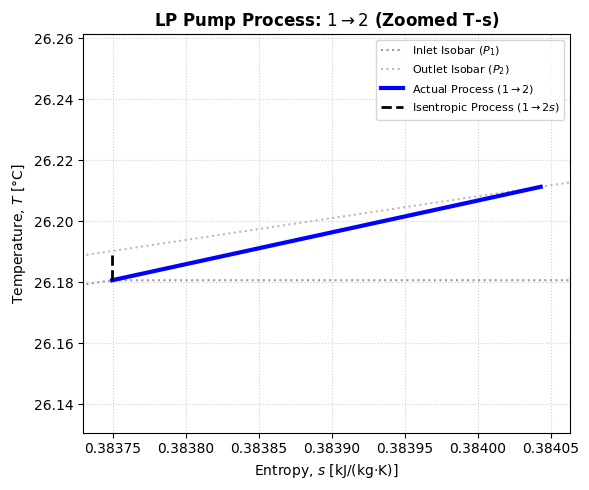

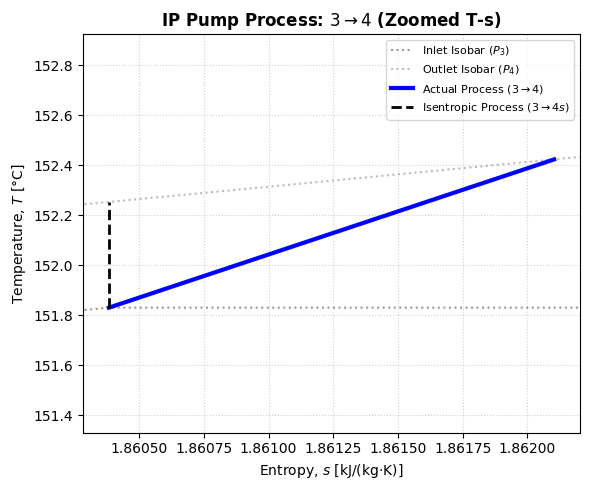

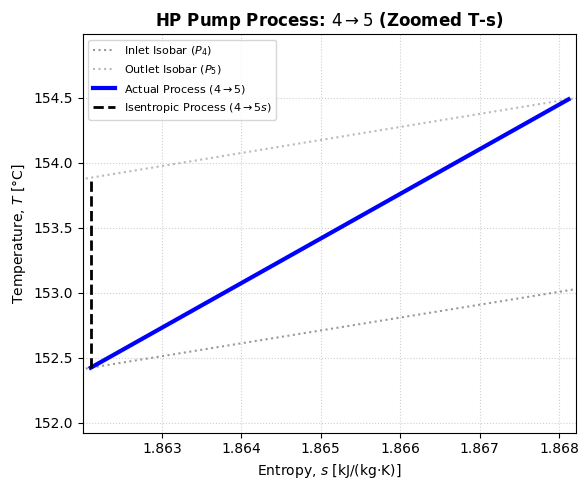

In [ ]:
# ZOOMED IN PLOTS

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from CoolProp.CoolProp import PropsSI


# --- 1. INPUT PARAMETERS (Re-defining for standalone execution) ---
p_hp = 177e5      # HP: 177 bar
p_reheat = 43e5    # IP/Reheat: 43 bar
p_lp = 5e5         # LP: 5 bar
p_cond = 0.034e5   # Condenser: 0.034 bar
T_hp_superheat = 599 + 273.15
eta_pump_isen = 0.85
eta_turb_isen = 0.92
m_dot_HP = 152.5
m_dot_IP_add = 14.44

# ----------------------------------------------------------------------
# --- 2. CYCLE STATE POINT CALCULATIONS (Needed to define T/S/h points) ---
# ----------------------------------------------------------------------
P1 = p_cond
h1 = PropsSI('H', 'P', P1, 'Q', 0, 'Water') / 1000
s1 = PropsSI('S', 'P', P1, 'Q', 0, 'Water') / 1000

P2 = p_lp
h2s = PropsSI('H', 'P', P2, 'S', s1 * 1000, 'Water') / 1000
h2 = h1 + (h2s - h1) / eta_pump_isen
s2 = PropsSI('S', 'P', P2, 'H', h2 * 1000, 'Water') / 1000


P3 = p_lp
h3 = PropsSI('H', 'P', P3, 'Q', 0, 'Water') / 1000
s3 = PropsSI('S', 'P', P3, 'Q', 0, 'Water') / 1000

P4 = p_reheat
h4s = PropsSI('H', 'P', P4, 'S', s3 * 1000, 'Water') / 1000
h4 = h3 + (h4s - h3) / eta_pump_isen
s4 = PropsSI('S', 'P', P4, 'H', h4 * 1000, 'Water') / 1000


P5 = p_hp
h5s = PropsSI('H', 'P', P5, 'S', s4 * 1000, 'Water') / 1000
h5 = h4 + (h5s - h4) / eta_pump_isen
s5 = PropsSI('S', 'P', P5, 'H', h5 * 1000, 'Water') / 1000

# Calculate all T and S values for the Pandas Series setup
actual_points = {
    '1 (Cond. Sat Liq)': {'P': P1, 'H': h1, 'S': s1}, '2 (Pumped LP)': {'P': P2, 'H': h2, 'S': s2},
    '3 (Sat LP Liq)': {'P': P3, 'H': h3, 'S': s3}, '4 (Pumped IP)': {'P': P4, 'H': h4, 'S': s4},
    '5 (Pumped HP)': {'P': P5, 'H': h5, 'S': s5},
    # Dummy values for remaining points to complete the structure (not used for plotting pump efficiency)
    '6 (SHP Turb In)': {'P': p_hp, 'H': PropsSI('H', 'P', p_hp, 'T', T_hp_superheat, 'Water') / 1000, 'S': PropsSI('S', 'P', p_hp, 'T', T_hp_superheat, 'Water') / 1000},
    '7 (HP Turb Ex)': {'P': p_reheat, 'H': 3240, 'S': 7.1},
    '8 (Reheat/IP In)': {'P': p_reheat, 'H': 3670, 'S': 7.6},
    '9 (IP Turb Ex)': {'P': p_lp, 'H': 2880, 'S': 7.8},
    '10 (LP Turb Ex)': {'P': p_cond, 'H': 2250, 'S': 8.0}
}
table_data = {}
for name, props in actual_points.items():
    P = props['P']; H = props['H'] * 1000; S = props['S'] * 1000
    T = PropsSI('T', 'P', P, 'H', H, 'Water')
    table_data[name] = {'T (°C)': T - 273.15, 's (kJ/kg·K)': S / 1000}

df_cycle = pd.DataFrame.from_dict(table_data, orient='index').reindex(actual_points.keys())
Ts = df_cycle['T (°C)'] + 273.15; Ss = df_cycle['s (kJ/kg·K)'] # T in K, S in kJ/kg·K

# Helper function for zoomed-in isobaric line (T in °C, S in kJ/kg·K)
def plot_isobaric_zoomed(p, s_start, s_end, ax, color='gray', lw=1, linestyle='--', label=None):
    """Plots a line of constant pressure precisely between two entropy bounds for a zoomed plot."""
    s_vals_k_J = np.linspace(s_start * 1000, s_end * 1000, 100)
    T_vals_C = []
    s_plot_vals = []

    for s in s_vals_k_J:
        try:
            T = PropsSI('T', 'P', p, 'S', s, 'Water')
        except ValueError:
            continue

        if np.isfinite(T):
            s_plot_vals.append(s / 1000)
            T_vals_C.append(T - 273.15)

    if len(s_plot_vals) > 1:
        ax.plot(s_plot_vals, T_vals_C, color=color, lw=lw, ls=linestyle, alpha=0.8, label=label)


# ----------------------------------------------------------------------
# --- 3. ZOOMED PUMPING PROCESS PLOTS ---
# ----------------------------------------------------------------------

# Extracting State Points (T in °C, S in kJ/kg·K)
s1_val, T1_val = Ss['1 (Cond. Sat Liq)'], Ts['1 (Cond. Sat Liq)'] - 273.15
s2_val, T2_val = Ss['2 (Pumped LP)'], Ts['2 (Pumped LP)'] - 273.15
T2s_val = PropsSI('T', 'P', P2, 'H', h2s * 1000, 'Water') - 273.15
s2s_val = s1_val

s3_val, T3_val = Ss['3 (Sat LP Liq)'], Ts['3 (Sat LP Liq)'] - 273.15
s4_val, T4_val = Ss['4 (Pumped IP)'], Ts['4 (Pumped IP)'] - 273.15
T4s_val = PropsSI('T', 'P', P4, 'H', h4s * 1000, 'Water') - 273.15
s4s_val = s3_val

s4_HP_val, T4_HP_val = s4_val, T4_val
s5_val, T5_val = Ss['5 (Pumped HP)'], Ts['5 (Pumped HP)'] - 273.15
T5s_val = PropsSI('T', 'P', P5, 'H', h5s * 1000, 'Water') - 273.15
s5s_val = s4_HP_val

# --- LP Pump (1-2) Plot ---
fig2, ax2 = plt.subplots(figsize=(6, 5))
ax2.set_title('LP Pump Process: $1 \\rightarrow 2$ (Zoomed T-s)', fontweight='bold')
ax2.set_xlabel('Entropy, $s$ [kJ/(kg·K)]')
ax2.set_ylabel('Temperature, $T$ [°C]')
ax2.grid(True, linestyle=':', alpha=0.6)

plot_isobaric_zoomed(P1, s1_val - 0.0002, s2_val + 0.0002, ax2, color='gray', linestyle=':', lw=1.5, label='Inlet Isobar ($P_1$)')
plot_isobaric_zoomed(P2, s1_val - 0.0002, s2_val + 0.0002, ax2, color='darkgray', linestyle=':', lw=1.5, label='Outlet Isobar ($P_2$)')
ax2.plot([s1_val, s2_val], [T1_val, T2_val], 'b-', lw=3, label='Actual Process ($1 \\rightarrow 2$)')
ax2.plot([s1_val, s2s_val], [T1_val, T2s_val], 'k--', lw=2, label='Isentropic Process ($1 \\rightarrow 2s$)')


s_min_12 = min(s1_val, s2_val, s2s_val) - 0.00002
s_max_12 = max(s1_val, s2_val, s2s_val) + 0.00002
T_min_12 = min(T1_val, T2_val, T2s_val) - 0.05
T_max_12 = max(T1_val, T2_val, T2s_val) + 0.05
ax2.set_xlim(s_min_12, s_max_12)
ax2.set_ylim(T_min_12, T_max_12)
ax2.legend(loc='best', fontsize=8)
fig2.tight_layout()
plt.show() # Display the first plot

# --- IP Pump (3-4) Plot ---
fig3, ax3 = plt.subplots(figsize=(6, 5))
ax3.set_title('IP Pump Process: $3 \\rightarrow 4$ (Zoomed T-s)', fontweight='bold')
ax3.set_xlabel('Entropy, $s$ [kJ/(kg·K)]')
ax3.set_ylabel('Temperature, $T$ [°C]')
ax3.grid(True, linestyle=':', alpha=0.6)

plot_isobaric_zoomed(P3, s3_val - 0.0002, s4_val + 0.0002, ax3, color='gray', linestyle=':', lw=1.5, label='Inlet Isobar ($P_3$)')
plot_isobaric_zoomed(P4, s3_val - 0.0002, s4_val + 0.0002, ax3, color='darkgray', linestyle=':', lw=1.5, label='Outlet Isobar ($P_4$)')
ax3.plot([s3_val, s4_val], [T3_val, T4_val], 'b-', lw=3, label='Actual Process ($3 \\rightarrow 4$)')
ax3.plot([s3_val, s4s_val], [T3_val, T4s_val], 'k--', lw=2, label='Isentropic Process ($3 \\rightarrow 4s$)')


s_min_34 = min(s3_val, s4_val, s4s_val) - 0.0001
s_max_34 = max(s3_val, s4_val, s4s_val) + 0.0001
T_min_34 = min(T3_val, T4_val, T4s_val) - 0.5
T_max_34 = max(T3_val, T4_val, T4s_val) + 0.5
ax3.set_xlim(s_min_34, s_max_34)
ax3.set_ylim(T_min_34, T_max_34)
ax3.legend(loc='best', fontsize=8)
fig3.tight_layout()
plt.show() # Display the second plot

# --- HP Pump (4-5) Plot ---
fig4, ax4 = plt.subplots(figsize=(6, 5))
ax4.set_title('HP Pump Process: $4 \\rightarrow 5$ (Zoomed T-s)', fontweight='bold')
ax4.set_xlabel('Entropy, $s$ [kJ/(kg·K)]')
ax4.set_ylabel('Temperature, $T$ [°C]')
ax4.grid(True, linestyle=':', alpha=0.6)

plot_isobaric_zoomed(P4, s4_HP_val - 0.0002, s5_val + 0.0002, ax4, color='gray', linestyle=':', lw=1.5, label='Inlet Isobar ($P_4$)')
plot_isobaric_zoomed(P5, s4_HP_val - 0.0002, s5_val + 0.0002, ax4, color='darkgray', linestyle=':', lw=1.5, label='Outlet Isobar ($P_5$)')
ax4.plot([s4_HP_val, s5_val], [T4_HP_val, T5_val], 'b-', lw=3, label='Actual Process ($4 \\rightarrow 5$)')
ax4.plot([s4_HP_val, s5s_val], [T4_HP_val, T5s_val], 'k--', lw=2, label='Isentropic Process ($4 \\rightarrow 5s$)')


s_min_45 = min(s4_HP_val, s5_val, s5s_val) - 0.0001
s_max_45 = max(s4_HP_val, s5_val, s5s_val) + 0.0001
T_min_45 = min(T4_HP_val, T5_val, T5s_val) - 0.5
T_max_45 = max(T4_HP_val, T5_val, T5s_val) + 0.5
ax4.set_xlim(s_min_45, s_max_45)
ax4.set_ylim(T_min_45, T_max_45)
ax4.legend(loc='best', fontsize=8)
fig4.tight_layout()
plt.show() # Display the third plot

In [ ]:
import plotly.graph_objects as go

# --- Updated Thermodynamic Inputs ---
Q_in = 1411.90
W_gt = 593.00
Q_loss_gt = 14.59
Q_flue = 804.31

W_st = 295.00
Q_st_loss = 7.28
Q_stack = 98.92
Q_cond = 390.83

# Compute “miscellaneous” loss in HRSG/Steam cycle
Q_misc = Q_flue - W_st - Q_st_loss - Q_stack - Q_cond

# Net power output
W_net_total = W_gt + W_st

labels = [
    f"<b>Q_in (Fuel Input) ({Q_in:.2f} MW)</b>",            # 0
    f"<b>GT Net Power ({W_gt:.2f} MW)</b>",                 # 1
    f"<b>GT Losses ({Q_loss_gt:.2f} MW)</b>",               # 2
    f"<b>Flue Gas Heat ({Q_flue:.2f} MW)</b>",              # 3
    f"<b>ST Net Power ({W_st:.2f} MW)</b>",                 # 4
    f"<b>ST Losses ({Q_st_loss:.2f} MW)</b>",               # 5
    f"<b>Stack Loss ({Q_stack:.2f} MW)</b>",                # 6
    f"<b>Condenser Heat ({Q_cond:.2f} MW)</b>",             # 7
    f"<b>Misc Heat ({Q_misc:.2f} MW)</b>",                  # 8
    f"<b>Cooling System ({Q_loss_gt + Q_st_loss:.2f} MW)</u></b>",                               # 9
    f"<b>Net Power to Grid ({W_net_total:.2f} MW)</b>"      # 10
]

# FLOW DEFINITIONS
source = [
    # Q_in splits
    0, 0, 0,

    # Flue gas splits
    3, 3, 3, 3, 3,

    # Power merging to grid
    1, 4,

    # Heat losses merging to cooling system
    2, 5
]

target = [
    1, 2, 3,       # Q_in → GT power, GT loss, flue gas heat

    4, 5, 6, 7, 8, # Flue gas heat → ST power, ST loss, stack, condenser, misc

    10, 10,        # GT + ST net power → grid

    9, 9           # GT loss + ST loss → cooling system
]

value = [
    W_gt, Q_loss_gt, Q_flue,

    W_st, Q_st_loss, Q_stack, Q_cond, Q_misc,

    W_gt, W_st,

    Q_loss_gt, Q_st_loss
]

# Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=25,
        line=dict(color="black", width=0.5),
        label=labels,
        color=[
            '#4A148C', # Q_in
            '#008000', # GT Net Power
            '#C62828', # GT Loss
            '#1E88E5', # Flue Gas Heat
            '#008000', # ST Net Power
            '#C62828', # ST Loss
            '#757575', # Stack Loss
            '#FF6F00', # Condenser
            '#D32F2F', # Misc
            '#1976D2', # Cooling system
            '#004D40'  # Net to grid
        ]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        hovertemplate='%{source.label} → %{target.label}: %{value:.2f} MW<extra></extra>'
    )
)])

fig.update_layout(
    title_text="<b>Keadby 2 CCPP: Updated Energy Flow Sankey Diagram (MW)</b>",
    title_x=0.5,
    font_size=12,
    height=650,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()


In [ ]:
import plotly.graph_objects as go

# --- Updated Thermodynamic Inputs ---
Q_in = 1411.90
W_gt = 593.00
Q_loss_gt = 14.59
Q_flue = 804.31

W_st = 295.00
Q_st_loss = 7.28
Q_stack = 98.92
Q_cond = 390.83

# Compute “miscellaneous” loss in HRSG/Steam cycle
Q_misc = Q_flue - W_st - Q_st_loss - Q_stack - Q_cond # Result: 12.28 MW

# Net power output
W_net_total = W_gt + W_st # Result: 888.00 MW

labels = [
    f"<b>Q_in (Fuel Input) ({Q_in:.2f} MW)</b>",              # 0
    f"<b>GT Net Power ({W_gt:.2f} MW)</b>",                  # 1
    f"<b>GT Losses ({Q_loss_gt:.2f} MW)</b>",                # 2
    f"<b>Flue Gas Heat ({Q_flue:.2f} MW)</b>",               # 3
    f"<b>ST Net Power ({W_st:.2f} MW)</b>",                  # 4
    f"<b>ST Losses ({Q_st_loss:.2f} MW)</b>",                # 5
    f"<b>Stack Loss ({Q_stack:.2f} MW)</b>",                 # 6
    f"<b>Condenser Heat ({Q_cond:.2f} MW)</b>",              # 7
    f"<b>Misc Heat ({Q_misc:.2f} MW)</b>",                   # 8
    f"<b>Cooling System ({Q_loss_gt + Q_st_loss:.2f} MW)</b>", # 9
    f"<b>Net Power to Grid ({W_net_total:.2f} MW)</b>"       # 10
]

# FLOW DEFINITIONS
# (The index of the Condenser Heat link is 6)
source = [
    # Q_in splits (0, 1, 2)
    0, 0, 0,

    # Flue gas splits (3, 4, 5, 6, 7)
    3, 3, 3, 3, 3,

    # Power merging to grid (8, 9)
    1, 4,

    # Heat losses merging to cooling system (10, 11)
    2, 5
]

target = [
    1, 2, 3,         # Q_in -> GT power, GT loss, flue gas heat

    4, 5, 6, 7, 8, # Flue gas heat -> ST power, ST loss, stack, condenser, misc

    10, 10,          # GT + ST net power -> grid

    9, 9             # GT loss + ST loss -> cooling system
]

value = [
    W_gt, Q_loss_gt, Q_flue,

    W_st, Q_st_loss, Q_stack, Q_cond, Q_misc,

    W_gt, W_st,

    Q_loss_gt, Q_st_loss
]

# --- Link Color Customization ---
# Condenser Heat link is at index 6 in the source/target/value lists.
num_links = len(source)
link_colors = ['#E5E5E5'] * num_links # Default to light grey
condenser_link_index = 6
condenser_color = '#FF6F00' # Orange, matching the Condenser node
link_colors[condenser_link_index] = condenser_color
# --- End Link Color Customization ---

# Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=25,
        line=dict(color="black", width=0.5),
        label=labels,
        color=[
            '#4A148C', # Q_in (Purple)
            '#008000', # GT Net Power (Green)
            '#C62828', # GT Loss (Red)
            '#1E88E5', # Flue Gas Heat (Blue)
            '#008000', # ST Net Power (Green)
            '#C62828', # ST Loss (Red)
            '#757575', # Stack Loss (Grey)
            '#FF6F00', # Condenser (Orange)
            '#D32F2F', # Misc (Dark Red)
            '#1976D2', # Cooling system (Blue)
            '#004D40'  # Net to grid (Dark Green)
        ]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors, # Apply the custom link colors
        hovertemplate='%{source.label} \u2192 %{target.label}: %{value:.2f} MW<extra></extra>'
    )
)])

fig.update_layout(
    title_text="<b>Keadby 2 CCPP: Updated Energy Flow Sankey Diagram (MW)</b>",
    title_x=0.5,
    font_size=12,
    height=650,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show() # Use fig.show() in a Jupyter/Colab environment to display the chart

In [ ]:
import plotly.graph_objects as go

# --- Updated Thermodynamic Inputs ---
Q_in = 1411.90
W_gt = 593.00
Q_loss_gt = 14.59
Q_flue = 804.31

W_st = 295.00
Q_st_loss = 7.28
Q_stack = 98.92
Q_cond = 390.83

# Compute “miscellaneous” loss in HRSG/Steam cycle
Q_misc = Q_flue - W_st - Q_st_loss - Q_stack - Q_cond

# Net power output
W_net_total = W_gt + W_st

labels = [
    f"<b>Q_in (Fuel Input) ({Q_in:.2f} MW)</b>",              # 0
    f"<b>GT Net Power ({W_gt:.2f} MW)</b>",                  # 1
    f"<b>GT Losses ({Q_loss_gt:.2f} MW)</b>",                # 2
    f"<b>Flue Gas Heat ({Q_flue:.2f} MW)</b>",               # 3
    f"<b>ST Net Power ({W_st:.2f} MW)</b>",                  # 4
    f"<b>ST Losses ({Q_st_loss:.2f} MW)</b>",                # 5
    f"<b>Stack Loss ({Q_stack:.2f} MW)</b>",                 # 6
    f"<b>Condenser Heat ({Q_cond:.2f} MW)</b>",              # 7
    f"<b>Misc Heat ({Q_misc:.2f} MW)</b>",                   # 8
    f"<b>Cooling System ({Q_loss_gt + Q_st_loss:.2f} MW)</b>", # 9
    f"<b>Net Power to Grid ({W_net_total:.2f} MW)</b>"       # 10
]

# FLOW DEFINITIONS (Index of relevant links: 1, 4, 10, 11)
source = [
    # Q_in splits
    0, 0, 0, # Index 1 is Q_in -> GT Losses

    # Flue gas splits
    3, 3, 3, 3, 3, # Index 4 is Flue Gas Heat -> ST Losses

    # Power merging to grid
    1, 4,

    # Heat losses merging to cooling system
    2, 5 # Index 10 is GT Losses -> Cooling System, Index 11 is ST Losses -> Cooling System
]

target = [
    1, 2, 3,         # Q_in -> GT power, GT loss, flue gas heat

    4, 5, 6, 7, 8, # Flue gas heat -> ST power, ST loss, stack, condenser, misc

    10, 10,          # GT + ST net power -> grid

    9, 9             # GT loss + ST loss -> cooling system
]

value = [
    W_gt, Q_loss_gt, Q_flue,

    W_st, Q_st_loss, Q_stack, Q_cond, Q_misc,

    W_gt, W_st,

    Q_loss_gt, Q_st_loss
]

# --- Link Color Customization: Highlight GT and ST Losses leading to Cooling System ---
num_links = len(source)
link_colors = ['#E5E5E5'] * num_links # Default to light grey
loss_color = '#C62828' # Red, matching the loss nodes

# Indices for the links to color red:
# 1: Q_in -> GT Losses
# 4: Flue Gas Heat -> ST Losses
# 10: GT Losses -> Cooling System
# 11: ST Losses -> Cooling System
loss_indices = [1, 4, 10, 11]

for i in loss_indices:
    link_colors[i] = loss_color
# --- End Link Color Customization ---


# Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=25,
        line=dict(color="black", width=0.5),
        label=labels,
        color=[
            '#4A148C', # Q_in
            '#008000', # GT Net Power
            '#C62828', # GT Loss
            '#1E88E5', # Flue Gas Heat
            '#008000', # ST Net Power
            '#C62828', # ST Loss
            '#757575', # Stack Loss
            '#FF6F00', # Condenser
            '#D32F2F', # Misc
            '#1976D2', # Cooling system
            '#004D40'  # Net to grid
        ]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors, # Apply the custom link colors
        hovertemplate='%{source.label} \u2192 %{target.label}: %{value:.2f} MW<extra></extra>'
    )
)])

fig.update_layout(
    title_text="<b>Keadby 2 CCPP: Energy Flow Sankey Diagram (GT/ST Losses Highlighted)</b>",
    title_x=0.5,
    font_size=12,
    height=650,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show() # Use fig.show() to display the chart in a compatible environment (like Jupyter/Colab)